In [1]:
# Data Set: FD001
# Train trajectories: 100
# Test trajectories: 100
# Conditions: ONE (Sea Level)
# Fault Modes: ONE (HPC Degradation)

# Data Set: FD002
# Train trajectories: 260
# Test trajectories: 259
# Conditions: SIX 
# Fault Modes: ONE (HPC Degradation)

# Data Set: FD003
# Train trajectories: 100
# Test trajectories: 100
# Conditions: ONE (Sea Level)
# Fault Modes: TWO (HPC Degradation, Fan Degradation)

# Data Set: FD004
# Train trajectories: 248
# Test trajectories: 249
# Conditions: SIX 
# Fault Modes: TWO (HPC Degradation, Fan Degradation)


In [235]:
# Reference: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/

from IPython.display import HTML
import numpy as np
import pandas as pd
import calmap
import warnings
import itertools
import os
import shutil
import datetime
import seaborn as sns
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from category_encoders import *
from scipy.stats import pearsonr
from scipy.fftpack import fft
from scipy.signal import butter, lfilter, freqz, stft

from sklearn.metrics import mean_squared_log_error, mean_squared_error, make_scorer, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.base import clone

from lightgbm import LGBMRegressor
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_log_error
from math import sqrt

warnings.filterwarnings('ignore')
dataPath = '../data/'
pd.set_option('display.max_columns', None)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### 1. Restructure dataset(s)

In [151]:
train = pd.read_csv('../data/train_FD001.txt', sep=" ", header=None)
train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


- last 2 cols are 'nan': drop these

In [152]:
train.drop(train.columns[-2:], axis = 1, inplace = True)

##### Rename columns:

In [153]:
cols = ['unit_num', 'cycle']
opSetCols = ['opSetting' + str(i) for i in range(1,4)]
sensorCols = ['sensor' + str(i) for i in range(1,29-7)]
cols += opSetCols + sensorCols
len(train.columns), len(cols)

(26, 26)

In [154]:
train.columns = cols
train.head(2)

,unit_num,cycle,opSetting1,opSetting2,opSetting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236


In [155]:
train.shape, len(train.unit_num.unique()), len(train.cycle.unique())

((20631, 26), 100, 362)

##### Create target variable: 
- Choose maximum cycle for all units as failure
- Reverse order of cycles and set target variable equal to 'CyclesToFailure'

In [156]:
max_cycle = train.groupby('unit_num')['cycle'].max().reset_index()
max_cycle.rename(columns={'cycle': 'max_cycle'}, inplace = True)
max_cycle.head(2)

,unit_num,max_cycle
0,1,192
1,2,287


In [157]:
train = train.merge(max_cycle, left_on='unit_num', right_on='unit_num', how='outer')
train.head(2)

,unit_num,cycle,opSetting1,opSetting2,opSetting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,max_cycle
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192


In [158]:
train['CyclesToFailure'] = train.max_cycle - train.cycle
train.drop(['cycle', 'max_cycle'], axis = 1, inplace = True)
train.head(2)

,unit_num,opSetting1,opSetting2,opSetting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,CyclesToFailure
0,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190


#### 2. EDA
- Feature analysis
- Correlations with target variable
- missing-values
- outliers
- etc

##### Check for nan's

In [159]:
def checkMissingData(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head()

In [160]:
checkMissingData(train)

,Total,Percent
CyclesToFailure,0,0.0
sensor21,0,0.0
opSetting1,0,0.0
opSetting2,0,0.0
opSetting3,0,0.0


- no missing data

##### Determine if some features are categorical or not:
- determine also whether some features are also redundant

In [161]:
for i, col in enumerate(train.columns[1:-1]):
    print(len(train[col].value_counts()), end = ', ')
    #print('column_{}'.format(i+1), ' unique_values = {}'.format(len(train[col].value_counts())), end = ' | ')

158, 13, 1, 1, 310, 3012, 4051, 1, 2, 513, 53, 6403, 1, 159, 427, 56, 6078, 1918, 1, 13, 1, 1, 120, 4745, 

- Clearly some features are useless as they do not provide more than one type of value
    - remove columns 3, 4, 8, 13, 19, 21, 22

In [162]:
colIndicesToDrop = [3, 4, 8, 13, 19, 21, 22]
colsToDrop = []
for i, col_index in enumerate(colIndicesToDrop):
    colsToDrop.append(train.columns[col_index])
train.drop(colsToDrop, axis = 1, inplace = True)
train.head()

,unit_num,opSetting1,opSetting2,sensor2,sensor3,sensor4,sensor6,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure
0,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


In [163]:
print(train.columns)

Index(['unit_num', 'opSetting1', 'opSetting2', 'sensor2', 'sensor3', 'sensor4',
       'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12',
       'sensor13', 'sensor14', 'sensor15', 'sensor17', 'sensor20', 'sensor21',
       'CyclesToFailure'],
      dtype='object')


In [164]:
for i, col in enumerate(train.columns[1:-1]):
    print(len(train[col].value_counts()), end = ', ')
    #print('column_{}'.format(i+1), ' unique_values = {}'.format(len(train[col].value_counts())), end = ' | ')

158, 13, 310, 3012, 4051, 2, 513, 53, 6403, 159, 427, 56, 6078, 1918, 13, 120, 4745, 

##### Check correlations with target variable 
- check for individual unit_numbers

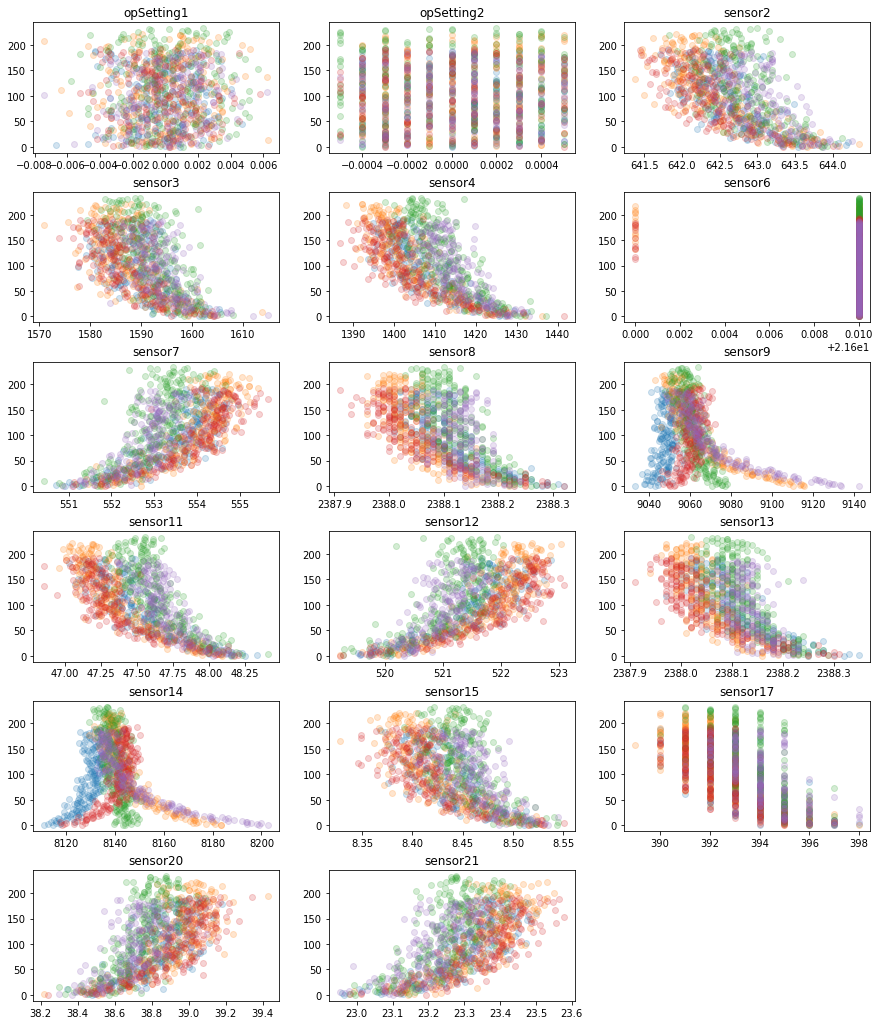

In [138]:
unit_num_list = [1, 10, 20, 30, 40]              # Selected unit-numbers

colList = train.columns[1:-1]
n_cols = 3                                       # 3 plots per row
rows = int(np.ceil(len(colList) / n_cols))    
f = plt.figure(figsize=(15,3*rows))

for i, col in enumerate(colList):
    
    axi = f.add_subplot(rows, n_cols, i+1)
    for i, unit_num in enumerate(unit_num_list):
        df = train[train.unit_num == unit_num]
        plt.scatter(df[col], df.CyclesToFailure, alpha = 0.2)# label = col + '_unit' + str(unit_num), alpha = 0.2)

    plt.title(col)
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

- clearly sensor17 and opSetting2 are categorical variables:
        - set their values to categorical numerical values

In [165]:
le = LabelEncoder()
cat_vars = ['sensor17', 'opSetting2']
for var in cat_vars:
      train[var] = le.fit_transform(train[var])

In [166]:
train.head(2)

,unit_num,opSetting1,opSetting2,sensor2,sensor3,sensor4,sensor6,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure
0,1,-0.0007,2,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,4,39.06,23.4190,191
1,1,0.0019,3,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,4,39.00,23.4236,190


In [167]:
train.dtypes

unit_num             int64
opSetting1         float64
opSetting2           int64
sensor2            float64
sensor3            float64
sensor4            float64
sensor6            float64
sensor7            float64
sensor8            float64
sensor9            float64
sensor11           float64
sensor12           float64
sensor13           float64
sensor14           float64
sensor15           float64
sensor17             int64
sensor20           float64
sensor21           float64
CyclesToFailure      int64
dtype: object

##### Heat Map

- Take unit-1 as an example

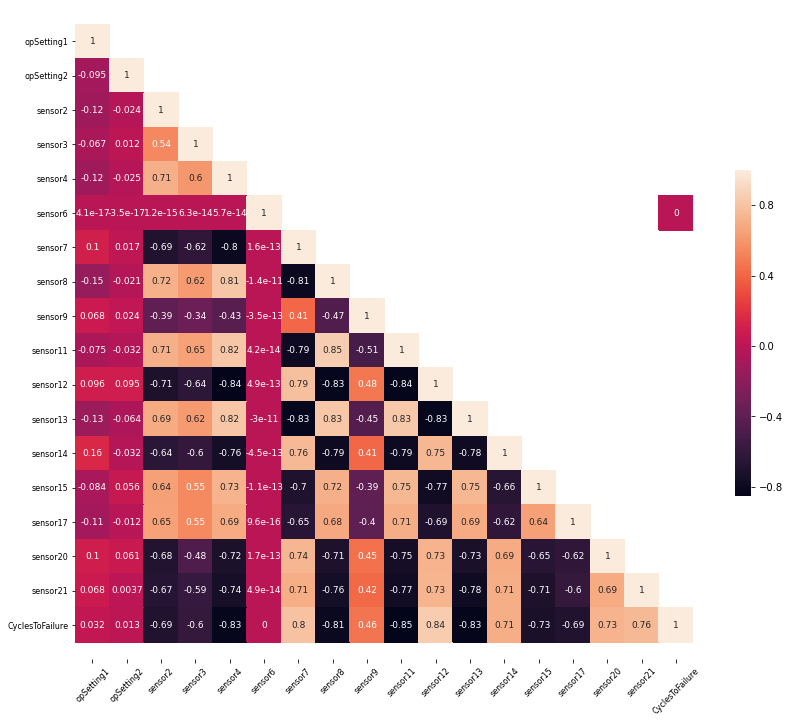

In [21]:
df = train[train.unit_num == 1]
df.drop(['unit_num'], axis = 1, inplace = True)
cor_mat= df[2:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(15,12)
ax = sns.heatmap(data=cor_mat,mask=mask,square=True,cbar_kws={"shrink": .5}, annot=True,cbar=True, annot_kws={"fontsize":9})
ylim_lower = (ax.get_ylim()[0] + 0.5)
ylim_upper = (ax.get_ylim()[1] - 0.5)
ax.set_ylim(ylim_lower, ylim_upper)
plt.xticks(rotation=45, fontsize = 8) 
_ = plt.yticks(rotation=0, fontsize = 8) 

- Sensor 6 clearly shows very little correlation with failure as seen in the scatter plot above
    - confirm with pearsons correlation for all unit-numbers:

In [168]:
train.sensor6.value_counts()

21.61    20225
21.60      406
Name: sensor6, dtype: int64

In [169]:
train.drop(['sensor6'], axis = 1, inplace = True)

- Further visualisation:
    - Scale each feature (holding unit_number constant) and then convert all to PCA 

In [170]:
def scaleData(df):
    mm = MinMaxScaler() #StandardScaler()
    df_ = df.copy()
    df_[df_.columns[1:-1]] = mm.fit_transform(df[df.columns[1:-1]])
    return df_

def convertToPCA(df, nComponents):
    pca = PCA(n_components=nComponents)
    pcaColList = [("PC" + str(x)) for x in range(nComponents)]
    pcaX = pca.fit_transform(df[df.columns[:-1]])
    df_PCA = pd.DataFrame(pcaX, columns=pcaColList)
    df_PCA['FailureGrade'] = df.FailureGrade.values
    return df_PCA

In [171]:
list_dfs = []
for unit_number in train.unit_num.unique():
    df = train[train.unit_num == unit_number]
    df_ = scaleData(df)
    list_dfs.append(df_)
    
train_ = pd.concat(list_dfs)

In [172]:
train_.head()

,unit_num,opSetting1,opSetting2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure
0,1,0.526316,0.000000,0.044,0.434626,0.180277,0.859155,0.18750,0.463380,0.338462,0.639640,0.131579,0.933895,0.332039,0.250,0.857143,0.850490,191
1,1,0.754386,0.111111,0.176,0.510776,0.245506,0.715962,0.12500,0.387638,0.353846,0.825826,0.263158,0.693423,0.411650,0.250,0.785714,0.858991,190
2,1,0.210526,0.777778,0.256,0.373204,0.272727,0.835681,0.25000,0.704537,0.184615,0.867868,0.157895,0.752108,0.321036,0.000,0.726190,0.712253,189
3,1,0.649123,0.444444,0.256,0.186422,0.212892,0.880282,0.34375,0.580922,0.076923,1.000000,0.289474,0.772344,0.000000,0.250,0.642857,0.767141,188
4,1,0.421053,0.222222,0.264,0.188578,0.324602,0.774648,0.18750,0.783494,0.192308,0.798799,0.184211,0.771332,0.396117,0.375,0.666667,0.823508,187


##### Set classes as follows:
- x < 70%         CyclesToFailure 
    - normal working condition
- 70% <= x < 90% CyclesToFailure           
    - degraded working condition
- 90% <= x       CyclesToFailure           
    - failing working condition

In [173]:
list_dfs = []
for unit_number in train_.unit_num.unique():
    df = train_[train_.unit_num == unit_number]
    df['FailureGrade'] = 0
    max_cycle = max(df.CyclesToFailure)
    mod_threshold = int(0.3*max_cycle)
    fail_threshold = int(0.1*max_cycle)
    df.loc[df.CyclesToFailure <= mod_threshold, 'FailureGrade'] = 1
    df.loc[df.CyclesToFailure <= fail_threshold, 'FailureGrade'] = 2
    list_dfs.append(df)
train_ = pd.concat(list_dfs)
train_.tail()

,unit_num,opSetting1,opSetting2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure,FailureGrade
20626,100,0.444444,0.3,0.800000,0.590143,0.868281,0.187032,0.655172,0.635007,0.748031,0.063333,0.935484,0.187578,0.654309,0.875,0.336538,0.062636,4,2
20627,100,0.333333,0.1,0.821739,0.797456,1.000000,0.044888,0.793103,0.621099,0.724409,0.126667,0.806452,0.119255,0.745992,0.625,0.153846,0.352290,3,2
20628,100,0.518519,0.6,0.769565,0.732591,0.856307,0.064838,0.827586,0.647897,0.763780,0.236667,0.870968,0.401863,1.000000,1.000,0.288462,0.000000,2,2
20629,100,0.379630,0.9,0.686957,0.821622,0.812400,0.000000,0.862069,0.913161,1.000000,0.123333,0.838710,0.292547,0.871242,0.625,0.144231,0.203646,1,2
20630,100,0.185185,0.1,0.956522,0.666455,0.961682,0.027431,0.896552,0.497965,0.850394,0.000000,0.935484,0.170807,0.694389,0.750,0.221154,0.185260,0,2


##### Remove unit_num and convert all scaled values to 2 PCA components
- visualise their distributions according to the 3 predefined classes above 

In [174]:
train_.drop('unit_num', axis = 1, inplace = True)

<Figure size 1080x216 with 0 Axes>

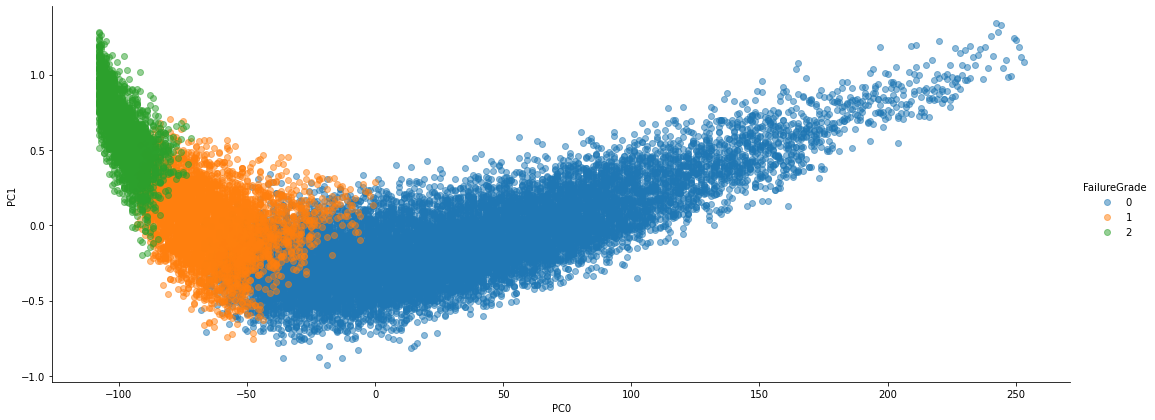

In [27]:
# Visualise failure grades through colours:
df = convertToPCA(train_, nComponents = 2)
f = plt.figure(figsize=(15,3))
explore = sns.PairGrid(data=df, x_vars = 'PC0', y_vars = 'PC1', hue="FailureGrade", size=6, aspect=2.5)
explore = explore.map(plt.scatter, alpha=0.5)
explore = explore.add_legend()

##### 3 Component PCA

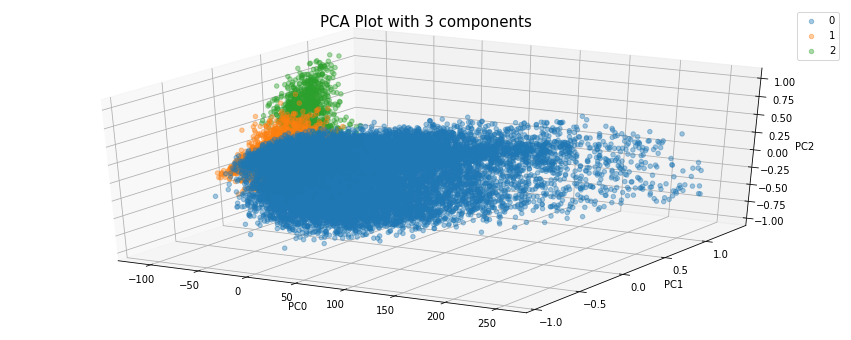

In [28]:
f = plt.figure(figsize=(15,6))
df = convertToPCA(train_, nComponents = 3)
ax = f.add_subplot(111, projection='3d')
for failure_grade in df.FailureGrade.unique():
    df_ = df[df.FailureGrade == failure_grade]
    ax.scatter(df_.PC0, df_.PC1, df_.PC2, marker='o', label = str(failure_grade), alpha = 0.4)

ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
plt.legend()
plt.title('PCA Plot with 3 components', fontsize = 15)
plt.show()

- Classes are clearly quite separable (slight overlap with failure-grades '0' and '1' as seen 2-component plot above:

#### 3. Regression & Classification dataset preparation

##### reshuffle datasets: 
    - (the dataset is still inherently ordered by unit number and cycles to failure)

In [175]:
train = train.sample(frac=1)
train_ = train_.sample(frac=1)
train_.head()

,opSetting1,opSetting2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure,FailureGrade
4379,0.669811,0.9,0.431034,0.240715,0.167026,0.944625,0.240000,0.074413,0.326316,0.627306,0.375000,0.697409,0.157171,0.142857,0.712329,0.752796,185,0
443,0.194444,0.8,0.584270,0.619528,0.807317,0.360870,0.566667,0.509268,0.574627,0.132275,0.647059,0.555895,0.693176,0.555556,0.267327,0.367919,35,1
497,0.762295,0.1,0.232653,0.117828,0.266393,0.675063,0.360000,0.027519,0.201389,0.726027,0.160000,0.111271,0.266508,0.111111,0.872093,0.879694,160,0
3217,0.444444,0.2,0.600000,0.593784,0.492518,0.552561,0.565217,0.067111,0.642857,0.441606,0.413793,0.315630,0.407223,0.000000,0.716216,0.532619,87,0
9372,1.000000,1.0,0.339623,0.300538,0.305525,0.860190,0.105263,0.067745,0.500000,0.590106,0.177419,0.116416,0.451014,0.250000,0.662921,0.473684,123,0


##### Drop columns which risk target leakage
    - drop unit_num to avoid target leakage:
    - drop opSetting variables as they may uniquely identify a unit and therefore identify give clues about failure (num_cycles etc)?

- classification dataframe

In [178]:
train_classif = train_.drop(['opSetting1', 'opSetting2', 'CyclesToFailure'], axis = 1)
train_classif.head(2)

,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,FailureGrade
4379,0.431034,0.240715,0.167026,0.944625,0.240000,0.074413,0.326316,0.627306,0.375000,0.697409,0.157171,0.142857,0.712329,0.752796,0
443,0.584270,0.619528,0.807317,0.360870,0.566667,0.509268,0.574627,0.132275,0.647059,0.555895,0.693176,0.555556,0.267327,0.367919,1


- regression dataframes

In [182]:
train_.drop(['FailureGrade', 'opSetting1', 'opSetting2'], axis = 1, inplace = True)
train_.head()

,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure
4379,0.431034,0.240715,0.167026,0.944625,0.240000,0.074413,0.326316,0.627306,0.375000,0.697409,0.157171,0.142857,0.712329,0.752796,185
443,0.584270,0.619528,0.807317,0.360870,0.566667,0.509268,0.574627,0.132275,0.647059,0.555895,0.693176,0.555556,0.267327,0.367919,35
497,0.232653,0.117828,0.266393,0.675063,0.360000,0.027519,0.201389,0.726027,0.160000,0.111271,0.266508,0.111111,0.872093,0.879694,160
3217,0.600000,0.593784,0.492518,0.552561,0.565217,0.067111,0.642857,0.441606,0.413793,0.315630,0.407223,0.000000,0.716216,0.532619,87
9372,0.339623,0.300538,0.305525,0.860190,0.105263,0.067745,0.500000,0.590106,0.177419,0.116416,0.451014,0.250000,0.662921,0.473684,123


In [180]:
train.drop(['unit_num', 'opSetting1', 'opSetting2'], axis = 1, inplace = True)
train.head(2)

,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure
995,642.53,1585.65,1401.78,553.95,2388.01,9075.63,47.12,521.78,2388.03,8158.85,8.4133,4,38.95,23.3417,120
1049,643.22,1589.02,1406.81,552.99,2388.06,9092.01,47.52,521.88,2388.07,8164.43,8.4343,7,38.89,23.2729,66


In [179]:
train.head()

,unit_num,opSetting1,opSetting2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure
995,5,-0.0008,4,642.53,1585.65,1401.78,553.95,2388.01,9075.63,47.12,521.78,2388.03,8158.85,8.4133,4,38.95,23.3417,120
1049,5,0.0015,10,643.22,1589.02,1406.81,552.99,2388.06,9092.01,47.52,521.88,2388.07,8164.43,8.4343,7,38.89,23.2729,66
20327,99,0.0040,6,642.39,1589.81,1401.18,553.91,2388.08,9048.36,47.39,522.01,2388.04,8141.53,8.4046,3,38.97,23.3228,103
7482,38,0.0006,7,643.09,1590.66,1419.83,552.77,2388.12,9100.11,47.89,519.91,2388.11,8177.36,8.4796,6,38.80,23.1763,27
13737,69,-0.0009,7,642.06,1581.32,1403.28,554.18,2388.06,9058.46,47.34,521.55,2388.06,8138.36,8.4116,5,38.91,23.4100,255


# ----------------------------------------------------------------------------------------------------------------
#### 4. Regression model
##### Define relevant functions

In [150]:
#### ---------------------------------- HELPER FUNCTIONS --------------------------------------------------------------------

def run_train_test_split(df, estimator):
    n_splits = 4
    X = df.drop(['CyclesToFailure'], axis = 1).values
    y = df.drop(df.columns.difference(['CyclesToFailure']), axis = 1).values
    rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
   
    #### Sometimes exception is thrown: (Need to address this issue)
    try:
        cval = cross_val_score(estimator, X, y, scoring=rmsle_scorer, cv=n_splits, n_jobs = -1)
        return cval.mean()
    except: 
        
        kf = KFold(n_splits, True, 1)
        rmsleScores = []

        for train_index, test_index in kf.split(X):
            trainX, testX = X[train_index], X[test_index]
            trainy, testy = y[train_index], y[test_index]
            model_ = clone(estimator)
            model_.fit(trainX,trainy)
            preds = model_.predict(testX)
            rmsleScore = rmsle(np.exp(testy), np.exp(preds))
            rmsleScores.append(rmsleScore)

        return round(sum(rmsleScores) / n_splits, 3)


## -----------------------------------------------------------------------------------------------------------------------

def testModel(df, n_splits, model, returnVal = False, printOutput = True, printFeatureImp = False, returnDataPoints = False):

    X = df.drop(['CyclesToFailure'], axis = 1).values
    y = df.drop(df.columns.difference(['CyclesToFailure']), axis = 1).values
    kf = KFold(n_splits, True, 1)
    rmsleScores = []
    
    datapoints = []
    
    if printOutput:
        print("RMSLE Value For Kf_i: ", end = ' ')
    for train_index, test_index in kf.split(X):
        trainX, testX = X[train_index], X[test_index]
        trainy, testy = y[train_index], y[test_index]
        model_ = clone(model)
        model_.fit(trainX,trainy)
        preds = model_.predict(testX)
        rmsleScore = rmsle(np.exp(testy), np.exp(preds))
        if returnDataPoints:
            datapoints.append([[testy], [preds]])
        rmsleScores.append(rmsleScore)
        if printOutput:
            print(round(rmsleScore, 2), end = ', ')
    if printOutput:
        print ("Average RMSLE: ", round(sum(rmsleScores) / n_splits, 3))
        if printFeatureImp:
            print("Features sorted by their score:")
            print(sorted(zip(map(lambda x: round(x, 4), model_.feature_importances_), df.columns[:-1]), 
                 reverse=True))        
    if returnVal & returnDataPoints:
        return round(sum(rmsleScores) / n_splits, 3), datapoints
    
    elif returnVal:
        return round(sum(rmsleScores) / n_splits, 3)
    
#### ---------------------------------- LOSS FUNCTION --------------------------------------------------------------------

def rmsle(ytrue, ypred):
    try:
        return np.sqrt(mean_squared_log_error(ytrue, ypred))
    #return np.sqrt(np.mean(np.square(np.log1p(ytrue) - np.log1p(ypred))))
    except:
        ypred = pd.DataFrame(ypred)
        print(ypred)#ypred[ypred<0]
    #return np.sqrt(mean_squared_log_error(ytrue + 100, ypred + 100)) # prevent negative log-values   
    
    
#### ---------------------------------- OPTIMISERS --------------------------------------------------------------------

# -------   RandomForest optimiser   -------
def optimiseRF(data, pbounds_):
    
    def train_bayes_opt_rforest(max_depth, min_impurity_decrease, n_estimators):
        params_ = {
            'max_depth': int(round(max_depth)),
            'min_impurity_decrease': float(min_impurity_decrease),
            'n_estimators': int(round(n_estimators))
        }
        mdl = RandomForestRegressor(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_rforest, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators']))
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   LightGBM optimiser   -------
def optimiseLightGBM(data, pbounds_):
    
    def train_bayes_opt_LightGBM(max_depth, gamma, learning_rate, n_estimators):
        params_ = {       
        'max_depth': int(round(max_depth)),
        'gamma': gamma,
        'learning_rate':learning_rate,
        'n_estimators':int(round(n_estimators))
        }
        mdl = LGBMRegressor(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_LightGBM, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators'])) 
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   GradientBoost optimiser   -------
def optimiseGradBoost(data, pbounds_):
    
    def train_bayes_opt_gradboost(max_depth, min_impurity_decrease, learning_rate, n_estimators):
        params_ = {       
        'max_depth': int(round(max_depth)),
        'min_impurity_decrease': min_impurity_decrease,
        'learning_rate':learning_rate,
        'n_estimators':int(round(n_estimators))
        }
        mdl = GradientBoostingRegressor(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_gradboost, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators'])) 
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   XGBoost optimiser   -------
def optimiseXGBoost(data, pbounds_):
    
    def train_bayes_opt_XGBoost(max_depth, gamma, learning_rate, n_estimators):
        params_ = {       
        'max_depth': int(round(max_depth)),
        'gamma': gamma,
        'learning_rate':learning_rate,
        'n_estimators':int(round(n_estimators))
        }
        mdl = xgb.XGBRegressor(**params_, silent = True)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_XGBoost, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators']))
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   Lasso optimiser   -------
def optimiseLasso(data, pbounds_):
    
    def train_bayes_opt_Lasso(alpha): #kernel, 
        params_ = {       
        #'kernel': kernel,
        'alpha': alpha
        }
        mdl = Lasso(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_Lasso, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max

    return max_params


## -----------------------------------------------------------------------------------------------------------------------

# -------   Ridge optimiser   -------
def optimiseRidge(data, pbounds_):
    
    def train_bayes_opt_Ridge(alpha): #kernel, 
        params_ = {       
        #'kernel': kernel,
        'alpha': alpha
        }
        mdl = Ridge(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_Ridge, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max

    return max_params

##### Quick test of random forest model with default features:
- Explore feature importance

In [32]:
rfModel = RandomForestRegressor(n_estimators=100)
testModel(df = train, n_splits = 4, model = rfModel, returnVal = False, printOutput = True, printFeatureImp = True)

RMSLE Value For Kf_i:  42.09, 41.76, 41.68, 41.27, Average RMSLE:  41.699
Features sorted by their score:
[(0.397, 'sensor11'), (0.1339, 'sensor4'), (0.1212, 'sensor9'), (0.053, 'sensor12'), (0.0429, 'sensor14'), (0.0382, 'sensor7'), (0.0364, 'sensor15'), (0.0343, 'sensor21'), (0.0316, 'sensor3'), (0.03, 'sensor2'), (0.027, 'sensor20'), (0.0223, 'sensor13'), (0.0209, 'sensor8'), (0.0111, 'sensor17')]


In [33]:
rfModel = RandomForestRegressor(n_estimators=100)
#run_train_test_split(train, rfModel)testModel
testModel(train, 4, rfModel, returnVal = False, printOutput = True, printFeatureImp = True)

RMSLE Value For Kf_i:  42.11, 41.7, 41.76, 41.3, Average RMSLE:  41.717
Features sorted by their score:
[(0.4012, 'sensor11'), (0.1271, 'sensor4'), (0.1229, 'sensor9'), (0.0545, 'sensor12'), (0.0421, 'sensor14'), (0.0381, 'sensor7'), (0.0368, 'sensor15'), (0.0346, 'sensor21'), (0.0315, 'sensor3'), (0.0305, 'sensor2'), (0.0267, 'sensor20'), (0.0219, 'sensor13'), (0.0214, 'sensor8'), (0.0108, 'sensor17')]


In [104]:
rfModel = RandomForestRegressor(n_estimators=100)
testModel(train_, 4, rfModel, returnVal = False, printOutput = True, printFeatureImp = True)

RMSLE Value For Kf_i:  36.63, 36.48, 36.1, 35.68, Average RMSLE:  36.223
Features sorted by their score:
[(0.464, 'sensor11'), (0.1093, 'sensor4'), (0.0846, 'sensor12'), (0.0656, 'sensor9'), (0.0483, 'sensor7'), (0.0335, 'sensor15'), (0.0315, 'sensor14'), (0.0298, 'sensor20'), (0.0283, 'sensor13'), (0.0282, 'sensor21'), (0.0244, 'sensor2'), (0.0226, 'sensor8'), (0.022, 'sensor3'), (0.0079, 'sensor17')]


- considerable improvement with scaled features

##### Optimise several models with Bayesian optimisation
- choose from lightGBM, RandomForest, GradientBoost & XGBoost as decision-tree based algorithms
- choose from linear regression (with without penalties) i.e. Lasso, Ridge 

##### Random Forest

In [37]:
bounds_ = {'n_estimators':(50, 250),
              'min_impurity_decrease':(0.0,0.01),
              'max_depth':(5,100)
             }

max_params = optimiseRF(train_, bounds_)                                      
rfModel = RandomForestRegressor(**max_params['params'])
testModel(df = train_, n_splits = 10, model = rfModel, printFeatureImp = True)

|   iter    |  target   | max_depth | min_im... | n_esti... |
-------------------------------------------------------------
|  1        | -0.3482   |  44.62    |  0.007203 |  50.02    |
|  2        | -0.3446   |  33.72    |  0.001468 |  68.47    |
|  3        | -0.3456   |  22.69    |  0.003456 |  129.4    |
|  4        | -0.3448   |  56.19    |  0.004192 |  187.0    |
|  5        | -0.3491   |  24.42    |  0.008781 |  55.48    |
|  6        | -0.3451   |  68.69    |  0.004173 |  161.7    |
|  7        | -0.3439   |  18.34    |  0.001981 |  210.1    |
|  8        | -0.3446   |  96.98    |  0.003134 |  188.5    |
|  9        | -0.3484   |  88.26    |  0.008946 |  67.01    |
|  10       | -0.3552   |  8.71     |  0.001698 |  225.6    |
|  11       | -0.3457   |  99.55    |  0.005485 |  249.7    |
|  12       | -0.423    |  5.115    |  0.005598 |  175.8    |
|  13       | -0.3448   |  46.19    |  0.004018 |  250.0    |
|  14       | -0.3475   |  99.89    |  0.009434 |  119.8    |
|  15   

##### LightGBM

In [38]:
bounds_ = {
        'gamma': (0,1),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseLightGBM(train_, bounds_)
lgbmMod = LGBMRegressor(**max_params['params'])
newVal = testModel(df = train_, n_splits = 10, model = lgbmMod)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.1601   |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.1602   |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.1816   |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.1608   |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.1634   |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.1982   |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.163    |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.1716   |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.1788   |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.1609   |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.1632   |  0.0      |  0.1      |  10.0     |  1e+03    |
|  12       | -0.1628   |  0.0      | 

##### Scikit-learn Gradient Boosting

In [39]:
bounds_ = {
        'min_impurity_decrease': (0.0,0.01),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseGradBoost(train_, bounds_)
gbModel = GradientBoostingRegressor(**max_params['params'])
newVal = testModel(df = train_, n_splits = 10, model = gbModel)

|   iter    |  target   | learni... | max_depth | min_im... | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.1729   |  0.3919   |  7.483    |  1.144e-0 |  337.2    |
|  2        | -0.1575   |  0.2027   |  1.831    |  0.001863 |  378.3    |
|  3        | -0.1735   |  0.3777   |  5.849    |  0.004192 |  701.0    |
|  4        | -0.1647   |  0.2431   |  8.903    |  0.000273 |  686.9    |
|  5        | -0.1726   |  0.3921   |  6.028    |  0.001404 |  238.2    |
|  6        | -0.1926   |  0.6605   |  9.714    |  0.003134 |  707.7    |
|  7        | -0.1968   |  0.7135   |  9.051    |  0.000850 |  87.1     |
|  8        | -0.1625   |  0.2189   |  8.903    |  0.000983 |  450.1    |
|  9        | -0.2042   |  0.7705   |  5.798    |  0.006919 |  349.7    |
|  10       | -0.1861   |  0.5806   |  8.512    |  0.000182 |  762.6    |
|  11       | -0.1587   |  0.1      |  1.0      |  0.01     |  1e+03    |
|  12       | -0.1608   |  0.8      | 

In [68]:
testModel(df = train_, n_splits = 10, model = gbModel)

RMSLE Value For Kf_i:  34.61, 34.6, 34.49, 34.73, 34.64, 33.37, 35.07, 34.73, 33.77, 35.65, Average RMSLE:  34.568


##### XGBoost

In [122]:
bounds_ = {'n_estimators':(50, 1000),
              'learning_rate':(0.1,0.8),
              'max_depth':(1,10),
               'gamma':(0,1),
             }

max_params = optimiseXGBoost(train_, bounds_)
xgbModel = xgb.XGBRegressor(**max_params['params'])
testModel(df = train_, n_splits = 10, model = xgbModel)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
                 0
0              inf
1     8.525820e+27
2              inf
3              inf
4              inf
5              inf
6     3.772694e+30
7              inf
8     1.664715e+05
9     4.831797e+08
10             inf
11    6.503230e+37
12             inf
13             inf
14             inf
15             inf
16             inf
17             inf
18             inf
19             inf
20             inf
21             inf
22    1.209856e+29
23    3.245463e+16
24             inf
25    2.300488e+28
26             inf
27             inf
28             inf
29             inf
30             inf
31    6.642562e+23
32             inf
33             inf
34    1.430925e+21
35             inf
36             inf
37             inf
38             inf
39             inf
40             inf
41             inf
42             inf
43    4.686369e+

                 0
0              inf
1     1.057995e+27
2              inf
3     1.968041e+20
4              inf
5     1.683619e+36
6              inf
7              inf
8              inf
9              inf
10             inf
11    1.325952e+21
12             inf
13    2.901278e+03
14             inf
15             inf
16             inf
17    2.554032e-03
18             inf
19             inf
20    9.348626e-03
21             inf
22             inf
23             inf
24    4.793268e-01
25             inf
26             inf
27             inf
28             inf
29    5.002882e+04
30    6.833375e+17
31    1.364359e+12
32    1.876998e+24
33             inf
34             inf
35    2.253159e+32
36             inf
37             inf
38             inf
39    2.132335e+12
40             inf
41             inf
42             inf
43             inf
44    6.967226e+05
45             inf
46             inf
47             inf
48             inf
49    2.018395e+18
50             inf
51          

                 0
0              inf
1              inf
2              inf
3              inf
4     8.558619e+31
5              inf
6              inf
7     1.903996e+29
8              inf
9              inf
10             inf
11             inf
12    1.755619e+13
13             inf
14             inf
15    7.825238e+08
16    4.903991e+02
17    3.829860e+10
18             inf
19    1.082105e+33
20    1.159436e+15
21             inf
22             inf
23             inf
24    5.399519e+15
25             inf
26             inf
27    1.049898e+27
28             inf
29             inf
30    1.084094e+13
31    7.976617e+21
32             inf
33             inf
34             inf
35    7.568739e+05
36    3.045133e+38
37    2.142936e+23
38    3.831924e+27
39             inf
40             inf
41    5.919206e+23
42             inf
43             inf
44             inf
45    4.147895e+04
46    8.593976e+14
47             inf
48             inf
49             inf
50             inf
51    1.1011

                 0
0     2.447673e+15
1              inf
2              inf
3              inf
4              inf
5              inf
6     4.532343e+17
7     2.517952e+21
8              inf
9              inf
10             inf
11             inf
12             inf
13    3.090722e+34
14             inf
15             inf
16    1.051093e+36
17             inf
18    5.168494e+10
19             inf
20             inf
21    1.407462e+28
22             inf
23    4.797815e+03
24             inf
25             inf
26             inf
27             inf
28    1.598865e+34
29             inf
30    2.467705e+28
31    2.175968e+23
32             inf
33             inf
34    7.689746e+25
35             inf
36    6.766189e+23
37    1.168536e+17
38             inf
39             inf
40    5.951219e+02
41             inf
42             inf
43             inf
44    9.744615e+31
45    4.826258e+18
46             inf
47             inf
48             inf
49             inf
50    6.790616e+00
51    4.8833

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

- XGBoost (with determined hyperparameters) predicts infinite values leading to a ValueError exception:
    - see below:

In [100]:
train_.head()

,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure
0,0.044,0.434626,0.180277,0.859155,0.18750,0.463380,0.338462,0.639640,0.131579,0.933895,0.332039,0.333333,0.857143,0.850490,191
1,0.176,0.510776,0.245506,0.715962,0.12500,0.387638,0.353846,0.825826,0.263158,0.693423,0.411650,0.333333,0.785714,0.858991,190
2,0.256,0.373204,0.272727,0.835681,0.25000,0.704537,0.184615,0.867868,0.157895,0.752108,0.321036,0.166667,0.726190,0.712253,189
3,0.256,0.186422,0.212892,0.880282,0.34375,0.580922,0.076923,1.000000,0.289474,0.772344,0.000000,0.333333,0.642857,0.767141,188
4,0.264,0.188578,0.324602,0.774648,0.18750,0.783494,0.192308,0.798799,0.184211,0.771332,0.396117,0.416667,0.666667,0.823508,187


In [105]:
testModel(df = train_, n_splits = 10, model = xgbModel)

RMSLE Value For Kf_i:  [16:09:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
                 0
0              inf
1              inf
2              inf
3              inf
4              inf
5     1.809490e+31
6              inf
7              inf
8              inf
9              inf
10             inf
11    3.282689e+29
12    1.788029e+08
13             inf
14    1.800959e+25
15             inf
16             inf
17    7.596287e+36
18             inf
19    1.403252e+26
20    9.360422e+34
21             inf
22             inf
23             inf
24             inf
25             inf
26    2.620537e+16
27    6.782597e+30
28             inf
29             inf
30             inf
31             inf
32             inf
33    1.129888e+20
34             inf
35             inf
36    2.841896e+07
37             inf
38             inf
39             inf
40             inf
41    5.727690e+31
42             inf
43             inf
44    

TypeError: type NoneType doesn't define __round__ method

##### Remove ordinal nature of categorical columns for linear models

- 'sensor17' is a categorical variable: 
    - Need to remove ordinal nature of data which could adversely affect linear-based techniques
        - convert to one-hot encoding
        - reduce number of dimensions through PCA (reduce risk of curse of dimensionality)

In [106]:
train_.sensor17 = train.sensor17

cat_vars = ['sensor17']
train_one = train_.copy()
for i, var in enumerate(cat_vars):
    temp = pd.get_dummies(train_one[var],prefix=var, drop_first = True )
    train_one = pd.concat([train_one,temp], axis=1)
    train_one.drop(var, axis=1, inplace = True)

print(train_one.shape)
cols = list(train_one)
cols.insert(len(cols)-1, cols.pop(cols.index('CyclesToFailure')))
train_one = train_one[cols]
train_one.head(2)

(20631, 26)


,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor20,sensor21,sensor17_1,sensor17_2,sensor17_3,sensor17_4,sensor17_5,sensor17_6,sensor17_7,sensor17_8,sensor17_9,sensor17_10,sensor17_11,sensor17_12,CyclesToFailure
8476,0.284133,0.103527,0.059689,0.710588,0.218750,0.166136,0.241667,0.641337,0.451613,0.014501,0.286875,0.836735,0.713389,0,0,0,0,1,0,0,0,0,0,0,0,160
9796,0.355556,0.420986,0.324595,0.558511,0.304348,0.103365,0.288288,0.666667,0.535714,0.084946,0.464307,0.892857,0.651309,0,0,0,0,1,0,0,0,0,0,0,0,112


##### Determine best number of components for PCA

In [41]:
def convertToPCA_reg(df, nComponents):
    pca = PCA(n_components=nComponents)
    pcaColList = [("PC" + str(x)) for x in range(nComponents)]
    pcaX = pca.fit_transform(df[df.columns[:-1]])
    df_PCA = pd.DataFrame(pcaX, columns=pcaColList)
    df_PCA['CyclesToFailure'] = df.CyclesToFailure.values
    return df_PCA

In [72]:
gbModel

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.20272912357197914, loss='ls',
                          max_depth=2, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.001862602113776709,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=378, n_iter_no_change=None,
                          presort='auto', random_state=None, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

number of Components:  = 1
RMSLE Value For Kf_i:  42.07, 41.73, 41.81, 42.67, 41.93, 40.73, 43.42, 42.07, 40.95, 42.99, Average RMSLE:  42.037
Features sorted by their score:
[(1.0, 'PC0')]
number of Components:  = 2
RMSLE Value For Kf_i:  37.89, 37.17, 37.48, 37.88, 38.08, 36.45, 38.49, 38.07, 36.7, 38.32, Average RMSLE:  37.653
Features sorted by their score:
[(0.8973, 'PC0'), (0.1027, 'PC1')]
number of Components:  = 3
RMSLE Value For Kf_i:  37.72, 37.0, 37.4, 37.69, 37.91, 36.25, 38.21, 38.13, 36.51, 38.1, Average RMSLE:  37.494
Features sorted by their score:
[(0.8485, 'PC0'), (0.1122, 'PC2'), (0.0393, 'PC1')]
number of Components:  = 4
RMSLE Value For Kf_i:  37.51, 36.81, 37.39, 37.71, 37.73, 36.18, 38.28, 37.79, 36.31, 38.4, Average RMSLE:  37.41
Features sorted by their score:
[(0.8414, 'PC0'), (0.0861, 'PC2'), (0.039, 'PC3'), (0.0335, 'PC1')]
number of Components:  = 5
RMSLE Value For Kf_i:  37.33, 36.44, 37.24, 37.42, 37.18, 35.48, 37.76, 37.53, 35.79, 37.71, Average RMSLE:  

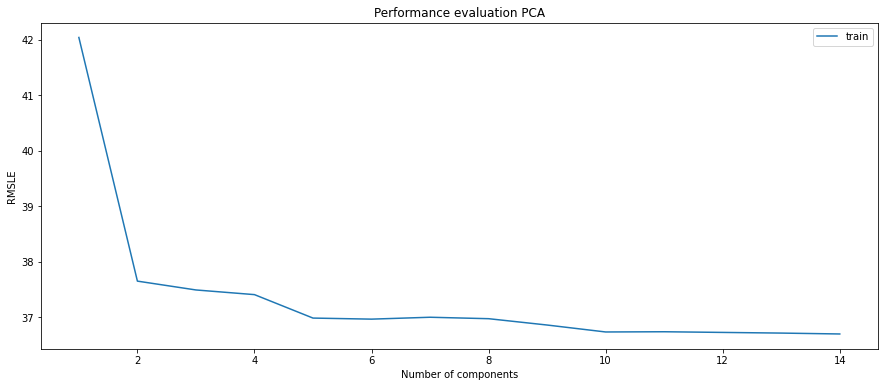

In [73]:
result = []
scaled_result = []
for nComponents in range(1, 15):
    print("{} = {}".format('number of Components: ', nComponents))
    df_PCA_one = convertToPCA_reg(train_one, nComponents)
    
    # Presaved Gradient Boosting max_params (best performing model):
    newVal = testModel(df = df_PCA_one, n_splits = 10, model = gbModel, returnVal = True, printFeatureImp = True)
    result.append(newVal)
    
f, axs = plt.subplots(1, 1, figsize=(15,6))
axs.plot(range(1, len(result)+1), result, label = 'train')
plt.legend()

_ = axs.set(xlabel="Number of components", ylabel='RMSLE', title='Performance evaluation PCA')

- PCA with 10 components (negligible change beyond)

In [107]:
df_PCA_one = convertToPCA_reg(train_one, 10)

##### Linear regression with/ without penalties and 14 principal components

In [108]:
df_PCA_one.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,CyclesToFailure
0,-0.618187,0.766093,0.035762,-0.098458,0.335892,0.044402,0.072153,-0.005726,-0.194447,-0.087809,160
1,-0.326495,0.774908,-0.037811,-0.154966,0.363995,0.120527,-0.022679,-0.012823,-0.016460,0.084042,112
2,-0.485190,0.767049,-0.005999,-0.116088,0.184767,0.012607,0.036297,-0.017875,-0.282821,-0.070424,99
3,0.154568,-0.086428,-0.168524,0.503838,0.444451,-0.637456,0.231366,-0.028402,0.066304,-0.047038,68
4,-0.324164,0.775881,-0.039851,-0.155586,0.343835,0.110754,-0.030923,-0.011192,0.052754,0.316840,125


In [109]:
df_PCA_one_ = df_PCA_one.copy()

##### Linear regression

In [110]:
lModel = LinearRegression()
newVal = testModel(df = df_PCA_one, n_splits = 10, model = lModel)

RMSLE Value For Kf_i:  41.0, 40.01, 39.52, 40.96, 39.11, 40.38, 40.2, 38.32, 39.84, 38.42, Average RMSLE:  39.777


##### Lasso regression

In [117]:
bounds_ = {
        'alpha': (0.001,1),
        }

max_params = optimiseLasso(df_PCA_one, bounds_)
lassoModel = Lasso(**max_params['params'])
newVal = testModel(df = df_PCA_one, n_splits = 10, model = lassoModel)

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        |  40.24    |  0.4176   |
|  2        |  40.67    |  0.7206   |
|  3        |  39.79    |  0.001114 |
|  4        |  40.1     |  0.303    |
|  5        |  39.9     |  0.1476   |
|  6        |  39.85    |  0.09325  |
|  7        |  39.94    |  0.1871   |
|  8        |  40.16    |  0.3462   |
|  9        |  40.22    |  0.3974   |
|  10       |  40.4     |  0.5393   |
|  11       |  41.01    |  1.0      |
|  12       |  41.01    |  1.0      |
|  13       |  41.01    |  1.0      |
|  14       |  41.01    |  1.0      |
|  15       |  41.01    |  1.0      |
|  16       |  41.01    |  1.0      |
|  17       |  41.01    |  1.0      |
|  18       |  41.01    |  1.0      |
|  19       |  41.01    |  1.0      |
|  20       |  41.01    |  1.0      |
|  21       |  41.01    |  1.0      |
|  22       |  41.01    |  1.0      |
|  23       |  41.01    |  1.0      |
|  24       |  41.01    |  1.0      |
|  25       

##### Ridge regression

In [118]:
bounds_ = {
        'alpha': (0.0000001,1),
        }

max_params = optimiseRidge(df_PCA_one, bounds_)
ridgeModel = Ridge(**max_params['params'])
newVal = testModel(df = df_PCA_one, n_splits = 10, model = ridgeModel)

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        |  39.79    |  0.417    |
|  2        |  39.79    |  0.7203   |
|  3        |  39.79    |  0.000114 |
|  4        |  39.79    |  0.3023   |
|  5        |  39.79    |  0.1468   |
|  6        |  39.79    |  0.09234  |
|  7        |  39.79    |  0.1863   |
|  8        |  39.79    |  0.3456   |
|  9        |  39.79    |  0.3968   |
|  10       |  39.79    |  0.5388   |
|  11       |  39.79    |  0.1418   |
|  12       |  39.79    |  0.7309   |
|  13       |  39.79    |  0.3906   |
|  14       |  39.79    |  0.7741   |
|  15       |  39.79    |  0.3443   |
|  16       |  39.79    |  0.1676   |
|  17       |  39.79    |  0.7919   |
|  18       |  39.79    |  0.6207   |
|  19       |  39.79    |  0.5876   |
|  20       |  39.79    |  0.3377   |
|  21       |  39.79    |  0.7688   |
|  22       |  39.79    |  0.9614   |
|  23       |  39.79    |  0.03482  |
|  24       |  39.79    |  0.1993   |
|  25       

##### Gradient Boosting was best performing:
- lets see how the predictions faired:

In [120]:
newVal, datapoints = testModel(df = train_, n_splits = 10, model = gbModel, returnVal = True, returnDataPoints = True)

RMSLE Value For Kf_i:  35.37, 34.75, 34.4, 35.29, 34.22, 34.55, 35.23, 33.27, 33.75, 33.28, Average RMSLE:  34.412


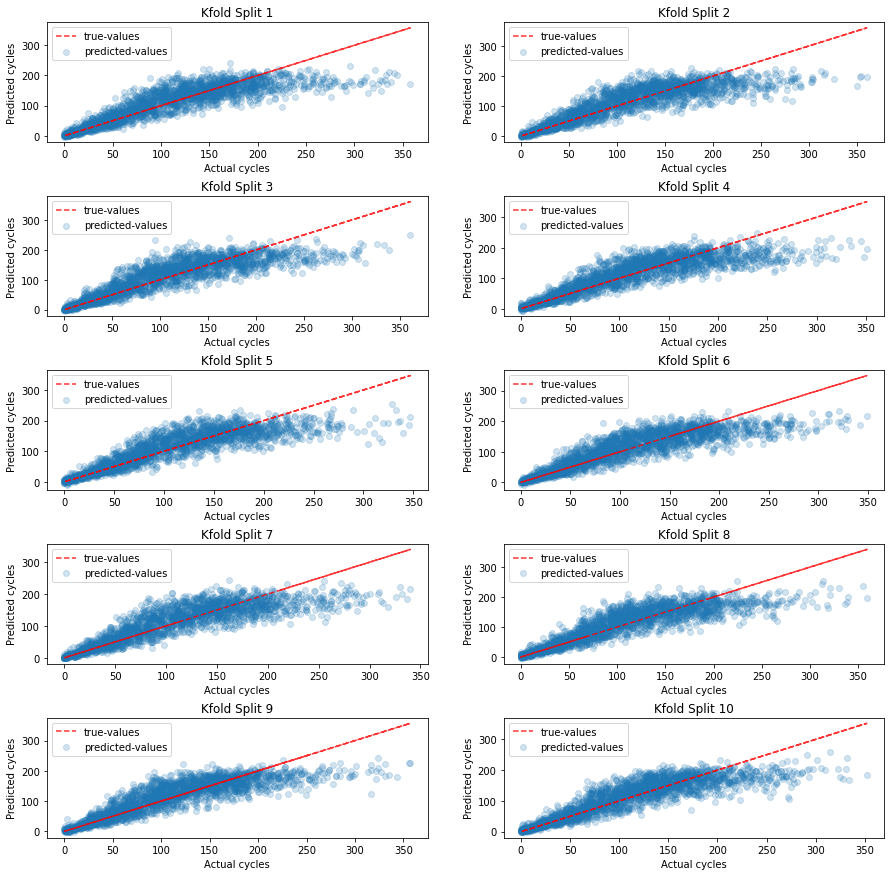

In [121]:
n_cols = 2                                       # 2 plots per row
rows = int(np.ceil(len(datapoints) / n_cols))
f = plt.figure(figsize=(15,3*rows))

for i in range(len(datapoints)):
    truePoints = datapoints[i][0]
    predPoints = datapoints[i][1]
    axi = f.add_subplot(rows, n_cols, i+1)
    plt.plot(datapoints[i][0][0], datapoints[i][0][0], 'r--', alpha = 0.8, label ='true-values')
    plt.scatter(datapoints[i][0], datapoints[i][1], alpha = 0.2, label ='predicted-values')
    axi.set_xlabel('Actual cycles')
    axi.set_ylabel('Predicted cycles')
    plt.title('Kfold Split ' + str(i+1), fontsize = 12)
    plt.legend()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.45)

# ----------------------------------------------------------------------------------------------------------------
#### 4. Classification model
##### Define relevant functions

- Try and predict one of 3 classes or **FailureGrades** 
- Try predict 3 classes and compare results with reducing to a 2-class problem

In [183]:
train_classif.head()

,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,FailureGrade
4379,0.431034,0.240715,0.167026,0.944625,0.240000,0.074413,0.326316,0.627306,0.375000,0.697409,0.157171,0.142857,0.712329,0.752796,0
443,0.584270,0.619528,0.807317,0.360870,0.566667,0.509268,0.574627,0.132275,0.647059,0.555895,0.693176,0.555556,0.267327,0.367919,1
497,0.232653,0.117828,0.266393,0.675063,0.360000,0.027519,0.201389,0.726027,0.160000,0.111271,0.266508,0.111111,0.872093,0.879694,0
3217,0.600000,0.593784,0.492518,0.552561,0.565217,0.067111,0.642857,0.441606,0.413793,0.315630,0.407223,0.000000,0.716216,0.532619,0
9372,0.339623,0.300538,0.305525,0.860190,0.105263,0.067745,0.500000,0.590106,0.177419,0.116416,0.451014,0.250000,0.662921,0.473684,0


In [184]:
train_classif.FailureGrade.unique()

array([0, 1, 2], dtype=int64)

In [233]:
# Average classwise accuracy given class sizes are imbalanced
def evaluate(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    cm_ = confusion_matrix(y_true, y_pred)
    cm = cm_.astype('float') / cm_.sum(axis=1)[:, np.newaxis]
    return np.nanmean(np.diagonal(cm)), cm_

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    sns.set(style="ticks", font_scale=1)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size= 12)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, size = 8)
    plt.yticks(tick_marks, classes, size = 8)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black", size= 20)

    plt.tight_layout()
    plt.ylabel('True label', size= 10)
    plt.xlabel('Predicted label', size= 10)


Avg Class-wise accuracy = 0.92


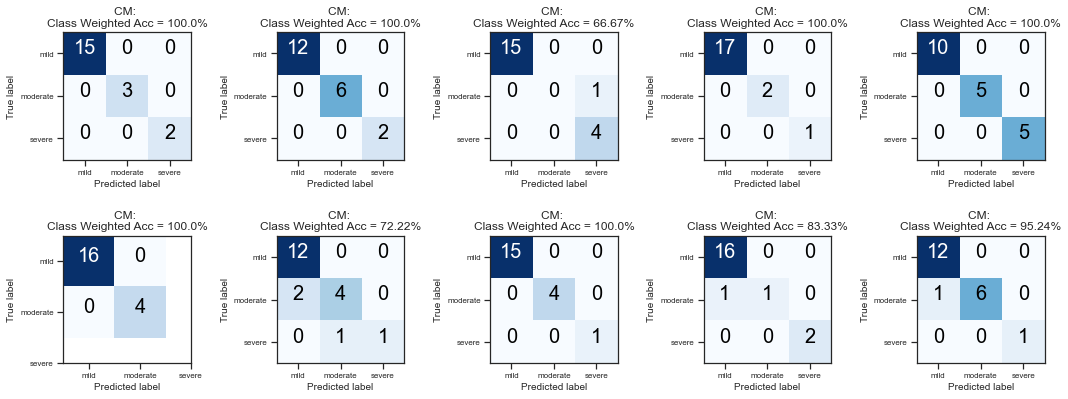

In [234]:
rf = RandomForestClassifier()

n_splits = 10
kf = KFold(n_splits, True, 1)
X = df.drop(['FailureGrade'], axis = 1).values
y = df.drop(df.columns.difference(['FailureGrade']), axis = 1).values

split_scores = []
cm_list = []
for train_index, test_index in kf.split(X):
    trainX, testX = X[train_index], X[test_index]
    trainy, testy = y[train_index], y[test_index]
    model_ = clone(rf)
    model_.fit(trainX,trainy)
    preds = model_.predict(testX)
    classWiseAcc, cm = evaluate(testy, preds)
    split_scores.append(classWiseAcc)
    cm_list.append(cm)
    #print('classWiseAcc = {}'.format(classWiseAcc))
    
            
print('Avg Class-wise accuracy = {}'.format(round(sum(split_scores)/len(split_scores), 2)))
n_cols = 5                                      # 2 plots per row
rows = int(np.ceil(len(cm_list) / n_cols))
f = plt.figure(figsize=(15,3*rows))
classes = ['mild', 'moderate', 'severe']
for i, cm in enumerate(cm_list):
    axi = f.add_subplot(rows, n_cols, i+1)
    plot_confusion_matrix(cm, classes, normalize=False, title='CM: \nClass Weighted Acc = '+ str(round(split_scores[i]*100, 2)) + '%', cmap=plt.cm.Blues)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.005)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = ensemble.RandomForestClassifier()
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf) ])
# tune the model
my_min_samples_leaf = [2, 25, 50]
my_max_depth = [8, 9, 10, 12]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_rf = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth)
                            , scoring = 'roc_auc'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_rf.fit(X_train, y_train)
# show the best model estimators
y_pred_proba = optimized_rf.predict_proba(X_test)[:, 1]
y_pred = optimized_rf.predict(X_test)
print(optimized_rf.best_estimator_)

##### Drop 'opSetting1' and 'opSetting2' given they provide little information:
- Check if they are engaged more/less at different stages of wear

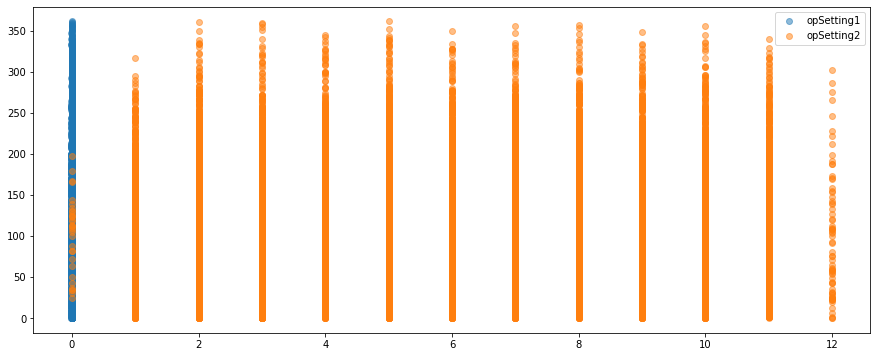

In [86]:
cols = ['opSetting1', 'opSetting2']
f = plt.figure(figsize=(15,6))

for col in cols:
    plt.scatter(train_[col], train_.CyclesToFailure, label = col, alpha = 0.5)
plt.legend()

In [ ]:
#### Remove 'opSetting1' & 'opSetting2' as 

#### Survival analysis needs constant behaviour of covariates with time! No changes allowed!

In [ ]:

['sensor' + str(i) for i in range(1,29-7)]
#colsToDrop = 
#[train.columns[]]
#train.drop